# Loading and rendering GLTF files
You can [import meshes from GLTF](https://kaolin.readthedocs.io/en/latest/modules/kaolin.io.gltf.html) and render them and plug the renderer into Kaolin's [interactive renderer](https://kaolin.readthedocs.io/en/latest/modules/kaolin.visualize.html).

In [1]:
pip install matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import glob
import math
import copy
import os

import torch
from matplotlib import pyplot as plt
from tutorial_common import COMMON_DATA_DIR

import kaolin as kal

## Loading a mesh
To import mesh data and materials into PyTorch tensors, simply call [kaolin.io.gltf.import_mesh](https://kaolin.readthedocs.io/en/latest/modules/kaolin.io.gltf.html#kaolin.io.gltf.import_mesh). The loaded data is returned as [SurfaceMesh class](https://kaolin.readthedocs.io/en/latest/modules/kaolin.rep.surface_mesh.html#kaolin.rep.SurfaceMesh) with contained materials of type [PBRMaterial class](https://kaolin.readthedocs.io/en/latest/modules/kaolin.render.materials.html#kaolin.render.materials.PBRMaterial). These containers make it very easy to inspect and preprocess the data.

You can also try loading other [GLTF sample models](https://github.com/KhronosGroup/glTF-Sample-Models/).

In [3]:
path = os.path.join(COMMON_DATA_DIR, 'meshes', 'avocado.gltf')
mesh = kal.io.gltf.import_mesh(path)

mesh = mesh.cuda()
mesh.vertices = kal.ops.pointcloud.center_points(
    mesh.vertices.unsqueeze(0), normalize=True).squeeze(0)

print(mesh)
print(f'\nFirst material: \n {mesh.materials[0]}')

/home/mshugrina/anaconda3/envs/kaolin-dev/lib/python3.8/site-packages/pygltflib-1.16.1-py3.8.egg/pygltflib/__init__.py:900: UserWarning: Conversion will leave avocado.bin file orphaned since data is now in the GLTF object.
/home/mshugrina/anaconda3/envs/kaolin-dev/lib/python3.8/site-packages/pygltflib-1.16.1-py3.8.egg/pygltflib/__init__.py:877: UserWarning: pygltflib currently unable to add image data to buffers.Please open an issue at https://gitlab.com/dodgyville/pygltflib/issues
/home/mshugrina/Documents/Coding/Kaolin/Dev/kaolin/kaolin/io/gltf.py:266: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:1105.)
  o

SurfaceMesh object with batching strategy NONE
            vertices: [406, 3] (torch.float32)[cuda:0]  
               faces: [682, 3] (torch.int64)[cuda:0]  
                 uvs: [406, 2] (torch.float32)[cuda:0]  
        face_uvs_idx: [682, 3] (torch.int64)[cuda:0]  
      vertex_normals: [406, 3] (torch.float32)[cuda:0]  
     vertex_tangents: [406, 3] (torch.float32)[cuda:0]  
material_assignments: [682] (torch.int16)[cuda:0]  
           materials: list of length 1
       face_vertices: if possible, computed on access from: (faces, vertices)
        face_normals: if possible, computed on access from: (normals, face_normals_idx) or (vertex_normals, faces) or (vertices, faces)
            face_uvs: if possible, computed on access from: (uvs, face_uvs_idx)
       vertex_colors: if possible, computed on access from: (faces, face_colors)
     vertex_features: if possible, computed on access from: (faces, face_features)
       face_tangents: if possible, computed on access from: (faces

## Rendering function and parameters
Let's initialize simple [Spherical Gaussian](https://kaolin.readthedocs.io/en/latest/modules/kaolin.render.lighting.html)
lighting, and a [Camera](https://kaolin.readthedocs.io/en/latest/modules/kaolin.render.camera.camera.html#kaolin.render.camera.Camera). 

To use the interactive visualizer, we must implement a rendering function that take a camera as input. Kaolin provides a standard shader `kal.render.easy_render.render_mesh` that can render imported `gltf` files with just one line.

CameraExtrinsics of 1 cameras, of coordinate system: 
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]). 
Camera #0 View Matrix: 
tensor([[[ 0.7071,  0.0000, -0.7071,  0.0000],
         [-0.4082,  0.8165, -0.4082,  0.0000],
         [ 0.5774,  0.5774,  0.5774, -1.7321],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0'),
Camera #0 Inverse View Matrix: 
tensor([[[ 0.7071, -0.4082,  0.5774,  1.0000],
         [ 0.0000,  0.8165,  0.5774,  1.0000],
         [-0.7071, -0.4082,  0.5774,  1.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')

PinholeIntrinsics of 1 cameras of resolution 512x512.
Camera #0: {'x0': 0.0, 'y0': 0.0, 'focal_x': 618.0386962890625, 'focal_y': 618.0386962890625}



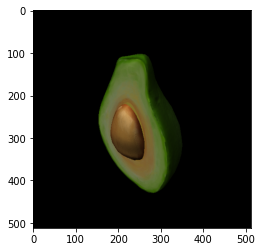

In [4]:
# Lighting parameters that are easy to control with sliders
azimuth = torch.zeros((1,), device='cuda')
elevation = torch.full((1,), math.pi / 3., device='cuda')
amplitude = torch.full((1, 3), 3., device='cuda')
sharpness = torch.full((1,), 5., device='cuda')

def current_lighting():
    """ Convert slider lighting parameters to paramater class used for rendering."""
    direction = kal.render.lighting.sg_direction_from_azimuth_elevation(azimuth, elevation)
    return kal.render.lighting.SgLightingParameters(
        amplitude=amplitude, sharpness=sharpness, direction=direction)

# Camera
camera = kal.render.easy_render.default_camera(512).cuda()
print(camera)

# Rendering
active_pass=kal.render.easy_render.RenderPass.render
def render(camera):
    """Render the mesh and its bundled materials.
    
    This is the main function provided to the interactive visualizer
    """
    render_res = kal.render.easy_render.render_mesh(camera, mesh, lighting=current_lighting())
    img = render_res[active_pass]
    return {"img": (torch.clamp(img, 0., 1.)[0] * 255.).to(torch.uint8),
            "normals": render_res[kal.render.easy_render.RenderPass.normals][0]}
    
def lowres_render(camera):
    """Render with lower dimension.
    
    This function will be used as a "fast" rendering used when the mouse is moving to avoid slow down.
    """
    lowres_cam = copy.deepcopy(camera)
    lowres_cam.width = camera.width // 8
    lowres_cam.height = camera.height // 8
    return render(lowres_cam)

output = render(camera)
plt.figure()
plt.imshow(output['img'].cpu().numpy())

## Interactive visualizer
To interactively inspect rendering from all sides, we can now plug the camera and the renderer into the interactive visualizer, adding some ipywidgets interactive sliders to modify lighting.

In [5]:
from ipywidgets import interactive, HBox, FloatSlider

visualizer = kal.visualize.IpyTurntableVisualizer(
    512, 512, copy.deepcopy(camera), render, fast_render=lowres_render, 
    max_fps=5, world_up_axis=1,
)

def sliders_callback(new_elevation, new_azimuth, new_amplitude, new_sharpness):
    """ipywidgets sliders callback"""
    with visualizer.out: # This is in case of bug
        elevation[:] = new_elevation
        azimuth[:] = new_azimuth
        amplitude[:] = new_amplitude
        sharpness[:] = new_sharpness
        # this is how we request a new update
        visualizer.render_update()
        
elevation_slider = FloatSlider(
    value=elevation.item(),
    min=-math.pi / 2.,
    max=math.pi / 2.,
    step=0.1,
    description='Elevation:',
    continuous_update=True,
    readout=True,
    readout_format='.1f',
)

azimuth_slider = FloatSlider(
    value=azimuth.item(),
    min=-math.pi,
    max=math.pi,
    step=0.1,
    description='Azimuth:',
    continuous_update=True,
    readout=True,
    readout_format='.1f',
)

amplitude_slider = FloatSlider(
    value=amplitude[0,0].item(),
    min=0.1,
    max=40.,
    step=0.1,
    description='Amplitude:\n',
    continuous_update=True,
    readout=True,
    readout_format='.1f',
)

sharpness_slider = FloatSlider(
    value=sharpness.item(),
    min=0.1,
    max=20.,
    step=0.1,
    description='Sharpness:\n',
    continuous_update=True,
    readout=True,
    readout_format='.1f',
)

interactive_slider = interactive(
    sliders_callback,
    new_elevation=elevation_slider,
    new_azimuth=azimuth_slider,
    new_amplitude=amplitude_slider,
    new_sharpness=sharpness_slider
)

# We combine all the widgets and the visualizer canvas and output in a single display
full_output = HBox([visualizer.canvas, interactive_slider])
display(full_output, visualizer.out)

Output()